# Movie Recomendation System

In [7]:
#imports and data proccessing

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from scipy.sparse.linalg import svds

#from nltk.corpus import wordnet
#from surprise import Reader, Dataset, SVD, evaluate

#import warnings; warnings.simplefilter('ignore')

#preproccessing matrixes
ratings_d = pd.read_csv("ratings.csv")
tags_d = pd.read_csv("tags.csv")
movies_d = pd.read_csv("movies.csv")
#timestamp is useless
ratings_d = ratings_d.drop("timestamp", axis= 1)
print(ratings_d.head())
tags_d = tags_d.drop("timestamp", axis= 1)

#print(ratings_d.head(), "\n")
#print(tags_d.head(), "\n")
#print(movies_d.head())

#Operate some SQL like matrix proccessing
join_df = pd.merge(tags_d, ratings_d, on=["movieId", "userId"], how="outer")
final_df = pd.merge(join_df, movies_d, on=["movieId"], how="outer")

print("\n\nALL_THINGS_JOINED:\n", final_df)
final_df.head(50)

#nan_mask = final_df["tag"].isna()
#rows_with_nan = final_df[nan_mask]
#rows_with_nan

#df_no_nan = final_df.dropna()
#df_no_nan

# LOGISTIC NOTES
# 3,476 rows with no nan vals
# 207 rows wit nan rating
# 99,201 rows with nan tag
# --------------------------
# 102,884 rows

   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


ALL_THINGS_JOINED:
         userId  movieId              tag  rating  \
0            2    60756            funny     5.0   
1            2    60756  Highly quotable     5.0   
2            2    60756     will ferrell     5.0   
3           62    60756           comedy     3.5   
4           62    60756            funny     3.5   
...        ...      ...              ...     ...   
102879     610   160341              NaN     2.5   
102880     610   160527              NaN     4.5   
102881     610   160836              NaN     3.0   
102882     610   163937              NaN     3.5   
102883     610   163981              NaN     3.5   

                                   title                 genres  
0                   Step Brothers (2008)                 Comedy  
1                   Step Brothers (2008)                 Co

,userId,movieId,tag,rating,title,genres
0,2,60756,funny,5.0,Step Brothers (2008),Comedy
1,2,60756,Highly quotable,5.0,Step Brothers (2008),Comedy
2,2,60756,will ferrell,5.0,Step Brothers (2008),Comedy
3,62,60756,comedy,3.5,Step Brothers (2008),Comedy
4,62,60756,funny,3.5,Step Brothers (2008),Comedy
5,62,60756,will ferrell,3.5,Step Brothers (2008),Comedy
6,424,60756,funny,4.0,Step Brothers (2008),Comedy
7,424,60756,will ferrell,4.0,Step Brothers (2008),Comedy
8,18,60756,NaN,3.0,Step Brothers (2008),Comedy
9,68,60756,NaN,2.5,Step Brothers (2008),Comedy


In [8]:
# Now we can start cutting off the table
# we need to find the movies with enough ratings from users to participate
# a very small amount of people is not a reliable source!
rate_count = ratings_d.groupby("movieId")["userId"].count().reset_index()
rate_count = pd.DataFrame(rate_count)
rate_count.rename(columns={'userId': 'count'}, inplace=True)
#sort
rate_count = rate_count.sort_values(by="count", ascending=False)

#keep the relible ones (value for enough ratings set by us)
#mean_count = rate_count["count"].mean()
#print("MC:", mean_count)

rate_count_80 = rate_count['count'].quantile(0.95)
print("RC:", rate_count_80)

min_votes_req = rate_count_80
rate_count = rate_count[rate_count["count"] >= min_votes_req]

rate_count.head(5000)

RC: 47.0


,movieId,count
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
...,...,...
7448,81834,47
2038,2717,47
1475,2001,47
1468,1994,47


In [9]:
last = pd.merge(final_df, rate_count, on=["movieId"], how="inner")

last = last.sort_values(by='count', ascending=False)
last.head(50000)

,userId,movieId,tag,rating,title,genres,count
13938,474,356,Vietnam,3.0,Forrest Gump (1994),Comedy|Drama|Romance|War,329
14158,401,356,NaN,3.5,Forrest Gump (1994),Comedy|Drama|Romance|War,329
14166,419,356,NaN,4.5,Forrest Gump (1994),Comedy|Drama|Romance|War,329
14165,418,356,NaN,4.0,Forrest Gump (1994),Comedy|Drama|Romance|War,329
14164,417,356,NaN,4.0,Forrest Gump (1994),Comedy|Drama|Romance|War,329
...,...,...,...,...,...,...,...
9162,298,1921,NaN,4.0,Pi (1998),Drama|Sci-Fi|Thriller,47
9161,287,1921,NaN,4.5,Pi (1998),Drama|Sci-Fi|Thriller,47
9160,282,1921,NaN,4.0,Pi (1998),Drama|Sci-Fi|Thriller,47
9159,274,1921,NaN,3.5,Pi (1998),Drama|Sci-Fi|Thriller,47


# Evaluating The Movies
#### At first we need to evalaute the movies and assign to them a rating so as to be able to have a list that can be sorted!
* we are gonna use the average rating wich is the simplest method but also
* the oficial IMDB evaluation formula

# Average Rating

In [10]:
#calc avgs
avgs = last.groupby("movieId")['rating'].mean().reset_index()
avgs.rename(columns={"rating" : "avg"}, inplace=True)

#join
final_with_avg = pd.merge(last, avgs, on=["movieId"], how="inner")
final_with_avg = final_with_avg.sort_values(by="avg", ascending=False)

selected_columns = ['movieId', 'title', 'genres', 'avg', 'count']
rate_list = final_with_avg[selected_columns]

Top_Movies = rate_list.drop_duplicates()
print("Top Movies:\n")
Top_Movies.head(40000)

Top Movies:



,movieId,title,genres,avg,count
1069,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.487603,307
595,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.432602,317
2955,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.402985,218
5352,858,"Godfather, The (1972)",Crime|Drama,4.289062,192
12859,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.278481,131
...,...,...,...,...,...
40051,172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,2.679245,53
34467,173,Judge Dredd (1995),Action|Crime|Sci-Fi,2.669355,62
39173,432,City Slickers II: The Legend of Curly's Gold (...,Adventure|Comedy|Western,2.645455,55
33881,435,Coneheads (1993),Comedy|Sci-Fi,2.420635,63


# IMDB Formula
Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

In [11]:
#alternative way to calculate
# We are gonna use the official IMDB formula for calculating a rating for the movies

global_avg = Top_Movies["avg"].mean()

Top_Movies['IMDB_AVG'] = (Top_Movies["count"] / (Top_Movies["count"] + min_votes_req))*Top_Movies["avg"] + (min_votes_req / (min_votes_req + Top_Movies["count"]))*global_avg

Top_Movies = Top_Movies.sort_values(by="IMDB_AVG", ascending=False)

print("Top Movies:\n")
Top_Movies.head(20)

Top Movies:



C:\Users\gramp\AppData\Local\Temp\ipykernel_9544\3306841226.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Top_Movies['IMDB_AVG'] = (Top_Movies["count"] / (Top_Movies["count"] + min_votes_req))*Top_Movies["avg"] + (min_votes_req / (min_votes_req + Top_Movies["count"]))*global_avg


,movieId,title,genres,avg,count,IMDB_AVG
1069,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.487603,307,4.376926
595,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.432602,317,4.332067
2955,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.402985,218,4.270145
5352,858,"Godfather, The (1972)",Crime|Drama,4.289062,192,4.164174
1970,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.244275,251,4.151176
3951,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.252404,204,4.140351
3508,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.244292,211,4.136757
12859,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.278481,131,4.113588
1565,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.183929,278,4.107292
13299,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.265385,129,4.102115


#### That is the simpest recomend that can be given! It just answers the simple question: Tell me a good movie
#### A tiny little bit of complexity is added whn the question becomes:  Tell me a good {insert_genre_here} movie

In [12]:
target_genre = 'Comedy'

# Check if the target genre is present in the "genre" column
genre_mask = Top_Movies['genres'].str.contains(target_genre, case=False)

# Filter the DataFrame to keep only rows with the target genre
Genre_Top = Top_Movies[genre_mask]

Genre_Top = Genre_Top.sort_values(by="avg", ascending=False)
Genre_Top.head(7)

,movieId,title,genres,avg,count,IMDB_AVG
1069,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.487603,307,4.376926
21484,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.264706,97,4.065376
10593,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.234266,142,4.089965
15471,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,4.183333,120,4.034357
11702,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.164234,136,4.033188
18582,1732,"Big Lebowski, The (1998)",Comedy|Crime,4.161765,106,4.005782
22549,4011,Snatch (2000),Comedy|Crime|Thriller,4.155914,93,3.987412


In [13]:
Genre_Top = Genre_Top.sort_values(by="IMDB_AVG", ascending=False)
Genre_Top.head(7)

,movieId,title,genres,avg,count,IMDB_AVG
1069,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.487603,307,4.376926
1,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.155224,329,4.092570
10593,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.234266,142,4.089965
21484,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.264706,97,4.065376
15471,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,4.183333,120,4.034357
11702,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.164234,136,4.033188
6675,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.105978,181,4.012806


# Comparing The Two Methods
The two methods only seem to differ signifficantly when really big amounts of data are used. Using the small data set they both work just fine. With tre original big data set the IMDB method shows better results cause its metric prioritises the movies with more reviews. We have to note that even with big data when choosing from a certain genre the IMDB apears to be a slightly better metric while the simple one is still prety good but 
##### In The End We Prefer The IMDB Method


# Colaborative Filtering
The listing method is pretty good and simple and it can surely recommend good movies to everyone. But thats the case! Not everyone has the same taste and the recommendations are better to be made suitable for the specific user's taste that asked for it! Thats what collaborative Filtering do. 

In [14]:
# in colaborating filtering we will need a user-movie matric
user_movie_matrix = ratings_d.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
mean_rating = np.nanmean(ratings_d.rating.values)
#print(mean_rating)
user_movie_matrix_filled = np.nan_to_num(user_movie_matrix.values, nan=0)

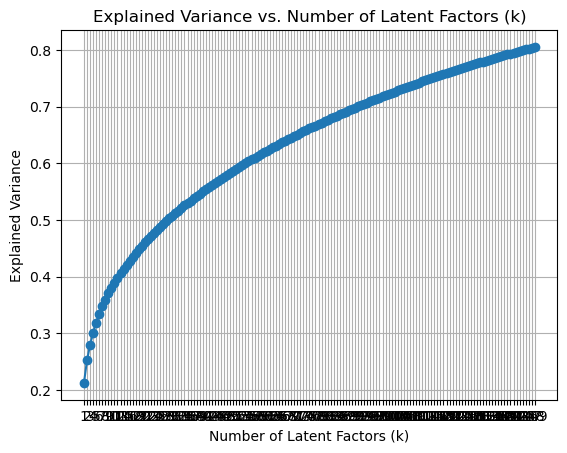

In [24]:
from scipy.sparse.linalg import svds

# for the correct explained_variance calculation we make sure that the matrix is filled 
# with zeros or if it filled with the mean then the mean is substracted from the sum of the denominator
explained_variances = []
#Range of values for k (number of latent factors)
k_values = range(1, 150)  # Adjust the range as needed


#Explained Variance = Sum(σ^2) / Sum(x^2)
#print(sigma_svd, user_movie_matrix_filled)
for k in k_values:
    U_svd, sigma_svd, Vt_svd = svds(user_movie_matrix_filled, k=k)
    explained_variance = np.sum(sigma_svd ** 2) / np.sum(np.sum((user_movie_matrix_filled)** 2))
    explained_variances.append(explained_variance)

# Plot the explained variances against different values of k
plt.plot(k_values, explained_variances, marker='o')
plt.title('Explained Variance vs. Number of Latent Factors (k)')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Explained Variance')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [23]:
# Applying Singular Value Decomposition (SVD) with k=120
U_svd, sigma_svd, Vt_svd = svds(user_movie_matrix_filled.astype(float), k=120)
sigma_svd = np.diag(sigma_svd)
svd_reconstructed_matrix = np.dot(np.dot(U_svd, sigma_svd), Vt_svd) #for weighted svd w be put here
                                                                    #bu of what value...


svd_df = pd.DataFrame(svd_reconstructed_matrix)
#print(svd_df.head(10000))

# Select the first 10 users
num_users_to_predict = 10
predicted_ratings_for_users = svd_df.iloc[:num_users_to_predict, :]

# Number of top ratings to find
top_ratings_count = 5
# Finding the top 5 ratings for each of the first 10 users
for user_id in range(num_users_to_predict):
    # Get the user's ratings
    user_ratings = predicted_ratings_for_users.iloc[user_id, :]
    
    # Find the top 5 ratings
    top_ratings_indices = user_ratings.nlargest(top_ratings_count).index
    top_ratings_values = user_ratings.nlargest(top_ratings_count).values
    
    # Print the results
    j=0
    print(f"User {user_id + 1}'s Top {top_ratings_count} Ratings:")
    for i in range(top_ratings_count):
        j+=1
        print(f"{j}: {movies_d['title'][top_ratings_indices[i]]}")
    print()
    

User 1's Top 5 Ratings:
1: Usual Suspects, The (1995)
2: Psycho (1960)
3: Sophie's Choice (1982)
4: Dirty Dozen, The (1967)
5: Star Wars: Episode V - The Empire Strikes Back (1980)

User 2's Top 5 Ratings:
1: Toy Story 3 (2010)
2: 10,000 BC (2008)
3: War Horse (2011)
4: Shawshank Redemption, The (1994)
5: Fear City: A Family-Style Comedy (La cité de la peur) (1994)

User 3's Top 5 Ratings:
1: Akira (1988)
2: Them! (1954)
3: Starman (1984)
4: G.I. Jane (1997)
5: Schindler's List (1993)

User 4's Top 5 Ratings:
1: Star Wars: Episode IV - A New Hope (1977)
2: Star Wars: Episode V - The Empire Strikes Back (1980)
3: Legend of 1900, The (a.k.a. The Legend of the Pianist on the Ocean) (Leggenda del pianista sull'oceano) (1998)
4: Final Conflict, The (a.k.a. Omen III: The Final Conflict) (1981)
5: Yellow Submarine (1968)

User 5's Top 5 Ratings:
1: Pulp Fiction (1994)
2: Shawshank Redemption, The (1994)
3: Schindler's List (1993)
4: Usual Suspects, The (1995)
5: Lion King, The (1994)

User 6'

# Comment
We used the elbow method to decide the value of the k with simple inspection with k ragning from 1 to 150 (long time to compute). We can see that the variance_explained follows a logarythmic trend. The k we chose was 120 because that explains a good amount (nearly 75%)  of the variance witch is consedered enough.

# Contetnt Based 
Now lets try to build a content based recommender but this time not with genres but with the tags that each user assigned to a movie he watched.The tags will provide us with a way to match movies based on latent factors(like directors, actors and emotions caused) that genre and rating can not show. To find the "matching" movies we are gonna calculate the cosine similarity after converting woeds to vectors. 
#### This system will answer the question: I liked that movie, can you recomend me similar ones???

In [137]:
#we are gnna need the tags file 
tags_d.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [138]:
#we will combine all the tags assigned to a movie by al the users in one row
#this will let us calculate cosine similarity
grouped_description = tags_d.groupby("movieId")["tag"].agg(lambda x: ' '.join(x)).reset_index()#that cobines the tags in one str
merged_description_d = pd.merge(tags_d, grouped_description, on="movieId", how="inner", suffixes=('_original', '_combined'))
#maybe a good idea would be to also put the genres assinged to the movie in the tag_combined
#but this would create a big bias in recomending same genre movies (wich we already did) overthrowing other latent factors

# keep only the combined tag column
merged_description_d = merged_description_d.drop(columns=["tag_original"]) #we dont need these two
merged_description_d = merged_description_d.drop(columns='userId')

merged_description_d = merged_description_d.drop_duplicates(subset=["movieId"])
merged_description_d.head(500000) # dont forget that this matrix is a product of tags_d

,movieId,tag_combined
0,60756,funny Highly quotable will ferrell comedy funn...
8,89774,Boxing story MMA Tom Hardy
11,106782,drugs Leonardo DiCaprio Martin Scorsese Stock ...
16,48516,way too long Leonardo DiCaprio suspense twist ...
26,431,Al Pacino gangster mafia
...,...,...
3677,1948,British
3678,5694,70mm
3679,6107,World War II
3680,7936,austere


In [139]:
join_merged_description = pd.merge(merged_description_d, Top_Movies, on=["movieId"], how="inner")
join_merged_description.head(500000)

,movieId,tag_combined,title,genres,avg,count,IMDB_AVG
0,106782,drugs Leonardo DiCaprio Martin Scorsese Stock ...,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama,3.973684,54,3.824916
1,48516,way too long Leonardo DiCaprio suspense twist ...,"Departed, The (2006)",Crime|Drama|Thriller,4.254386,107,4.071149
2,1221,Al Pacino Mafia Mafia,"Godfather: Part II, The (1974)",Crime|Drama,4.265385,129,4.102115
3,109487,black hole sci-fi time-travel Christopher Nola...,Interstellar (2014),Sci-Fi|IMAX,3.967949,73,3.844982
4,2,fantasy magic board game Robin Williams game,Jumanji (1995),Adventure|Children|Fantasy,3.441964,110,3.505437
...,...,...,...,...,...,...,...
329,112852,funny Great Visuals humorous unlikely hero,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi,4.024194,59,3.860047
330,116797,inspirational intelligent,The Imitation Game (2014),Drama|Thriller|War,4.000000,50,3.832346
331,122882,beautiful cinematography visually appealing,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller,3.826531,47,3.740261
332,134130,smart,The Martian (2015),Adventure|Drama|Sci-Fi,4.000000,48,3.828817


In [140]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(join_merged_description['tag_combined'])


In [141]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) #cosine similarity is the way

In [142]:
join_merged_description = join_merged_description.reset_index()
titles = join_merged_description['title']
indices = pd.Series(join_merged_description.index, index=join_merged_description['title'])

In [186]:
#lets make it a fuction that gets as an input a movie and returns similar ones
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6] #the sim_scores[0] is ecluded cause its the movie given
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [187]:
get_recommendations('Wolf of Wall Street, The (2013)').head(10)

1            Departed, The (2006)
89          Shutter Island (2010)
12           Blood Diamond (2006)
287    Catch Me If You Can (2002)
33                 Traffic (2000)
Name: title, dtype: object

In [188]:
get_recommendations('Interstellar (2014)').head(10)

112                              Stargate (1994)
186                    Back to the Future (1985)
226            Back to the Future Part II (1989)
321                            District 9 (2009)
57     Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Name: title, dtype: object

In [189]:
get_recommendations('Reservoir Dogs (1992)').head(10)

88     Inglourious Basterds (2009)
16             Pulp Fiction (1994)
14         Django Unchained (2012)
278          Ocean's Eleven (2001)
292        Italian Job, The (2003)
Name: title, dtype: object

In [190]:
get_recommendations('Dark Knight, The (2008)').head(10)


302      Garden State (2004)
137            Batman (1989)
198    Batman Returns (1992)
248          Superman (1978)
249       Superman II (1980)
Name: title, dtype: object

# GREAT!
As we can see the system recommends movies with the same director and actors (Wolf of Wall Street: Scorcese and Leonardo Di Caprio in them and Pulp Fiction: three Tarantino directed and two heist movies) , same genre and content (Interstellar: Sci-Fi, The Dark knight: Batman and other Superhero movies (dont know how Garden State ended up there tho...no ones perfect...)